In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import zipfile
import shutil
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import random
import matplotlib.image as mpimg
import random
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch.nn.functional as F

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


#COPYING THE DATA FOR FASTER TRAINING.

In [3]:
source_folder = '/content/drive/MyDrive/Airburn/'
destination_folder = '/content/zip'
shutil.copytree(source_folder, destination_folder)

'/content/zip'

In [4]:
zip_ref = zipfile.ZipFile("/content/zip/train_dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [5]:
zip_ref = zipfile.ZipFile("/content/zip/test_dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Airburn/train.csv')
df.head()

File Name        Class
0     1.jpg        other
1     2.jpg  bright dune
2     3.jpg        other
3     4.jpg       crater
4     5.jpg        other

In [ ]:
df.columns

Index(['File Name', 'Class'], dtype='object')

In [ ]:
df['Class'].unique()

array(['other', 'bright dune', 'crater', 'slope streak', 'dark dune',
       'swiss cheese', 'spider', 'impact ejecta'], dtype=object)

##ADDING PATHH

In [7]:
import os
image_directory = '/content/train_dataset'
df['File Name'] = df['File Name'].apply(lambda x: os.path.join(image_directory, x))
df.to_csv('updated_file.csv', index=False)

In [8]:
def view_random_images(df, num_images=4):
    fig,axs=plt.subplots(2, 2, figsize=(10, 10))

    for ax in axs.flat:
        random_iloc=random.randint(0,len(df)-1)
        random_image=df['File Name'][random_iloc]
        img=mpimg.imread(random_image)
        ax.imshow(img)
        ax.set_title(df['Class'][random_iloc])
        ax.axis("off")
        print(f"Image shape: {img.shape}")
    plt.tight_layout()
    plt.show()

Image shape: (227, 227)
Image shape: (227, 227)
Image shape: (227, 227)
Image shape: (227, 227)


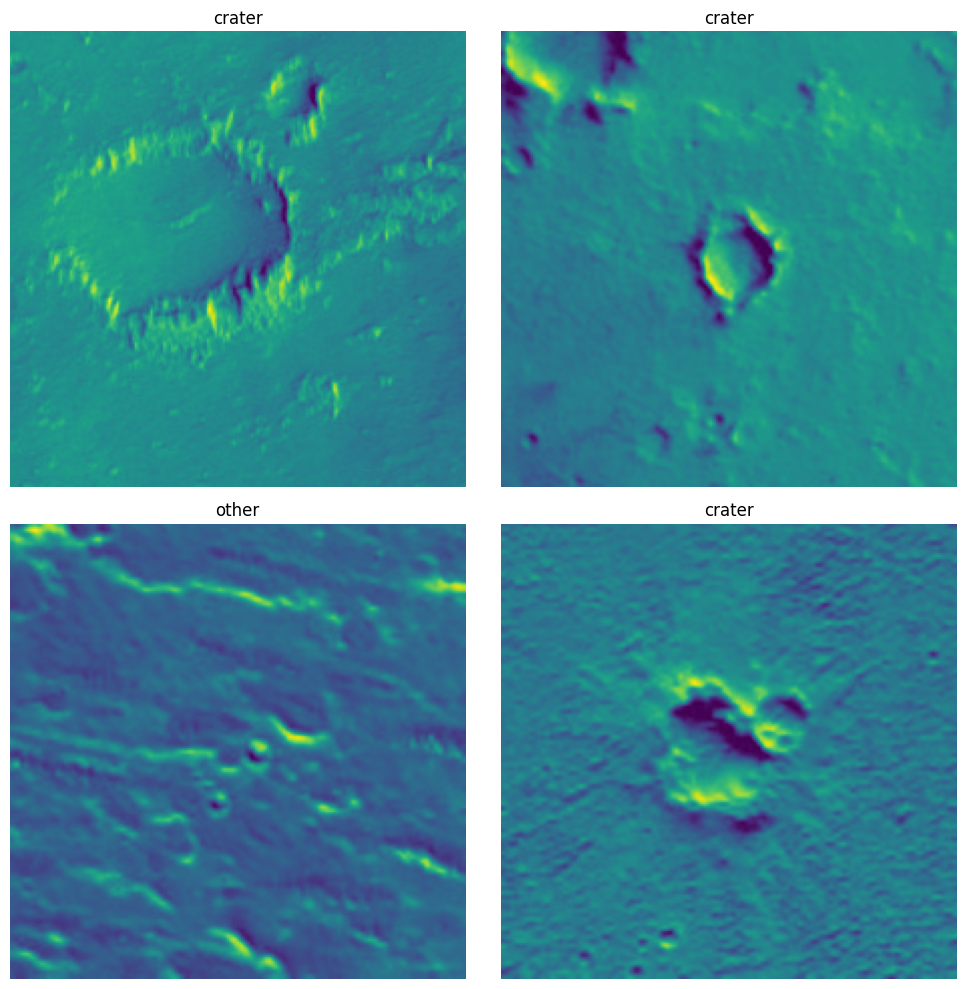

In [9]:
view_random_images(df)

#Processing the images

* *Note* : if you wish to run the code without augmenation please go to next section to first run simple CNN model. Also please  replace **File path** to **File Name**

* Also if you want to run simple CNN with data aug and preprocessing using below code run it!!

In [8]:
input_csv='/content/updated_file.csv'
output_dir='Processed_aug_train_images'
output_csv='Augmented_Up_train.csv'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

labels_df=pd.read_csv(input_csv)
datagen=ImageDataGenerator( #For data augmentation
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def preprocess_image(image_path): #preprocessing the images.
    image=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    image_normalized=image/255.0
    image_blurred =cv2.GaussianBlur(image_normalized,(5,5),0)
    image_equalized=cv2.equalizeHist((image_blurred*255).astype(np.uint8))
    return image_equalized

def save_augmented_images(image,image_name,label, augment_count=5):
    augmented_data=[]
    image_expanded=np.expand_dims(image,axis=0)
    image_expanded= np.expand_dims(image_expanded,axis=-1)
    augmented_images =datagen.flow(image_expanded,batch_size=1)
    for i in range(augment_count):
        augmented_image=next(augmented_images)[0].astype(np.uint8)
        augmented_image=augmented_image.squeeze()
        augmented_filename=f"{os.path.splitext(image_name)[0]}_aug_{i}.png"
        output_path=os.path.join(output_dir,augmented_filename)
        cv2.imwrite(output_path,augmented_image)
        augmented_data.append({'File path': output_path, 'Class': label})
    return augmented_data

new_data = []
for index,row in labels_df.iterrows():
    image_path= row['File Name']
    label=row['Class']
    image_name= os.path.basename(image_path)
    processed_image=preprocess_image(image_path)
    processed_image_path=os.path.join(output_dir,image_name)
    cv2.imwrite(processed_image_path,processed_image)
    new_data.append({'File path': processed_image_path, 'Class': label})
    augmented_data=save_augmented_images(processed_image, image_name, label)
    new_data.extend(augmented_data)
augmented_labels_df=pd.DataFrame(new_data)
augmented_labels_df.to_csv(output_csv, index=False)
print(f"Processing, augmentation, and labeling completed.")
print(f"Total training data : f{len(augmented_labels_df)}")

Processing, augmentation, and labeling completed.
Total training data : f37206


##Visualization

Original Image shape: (227, 227)
Augmented Image 0 shape: (227, 227)
Augmented Image 1 shape: (227, 227)
Augmented Image 2 shape: (227, 227)
Augmented Image 3 shape: (227, 227)
Augmented Image 4 shape: (227, 227)


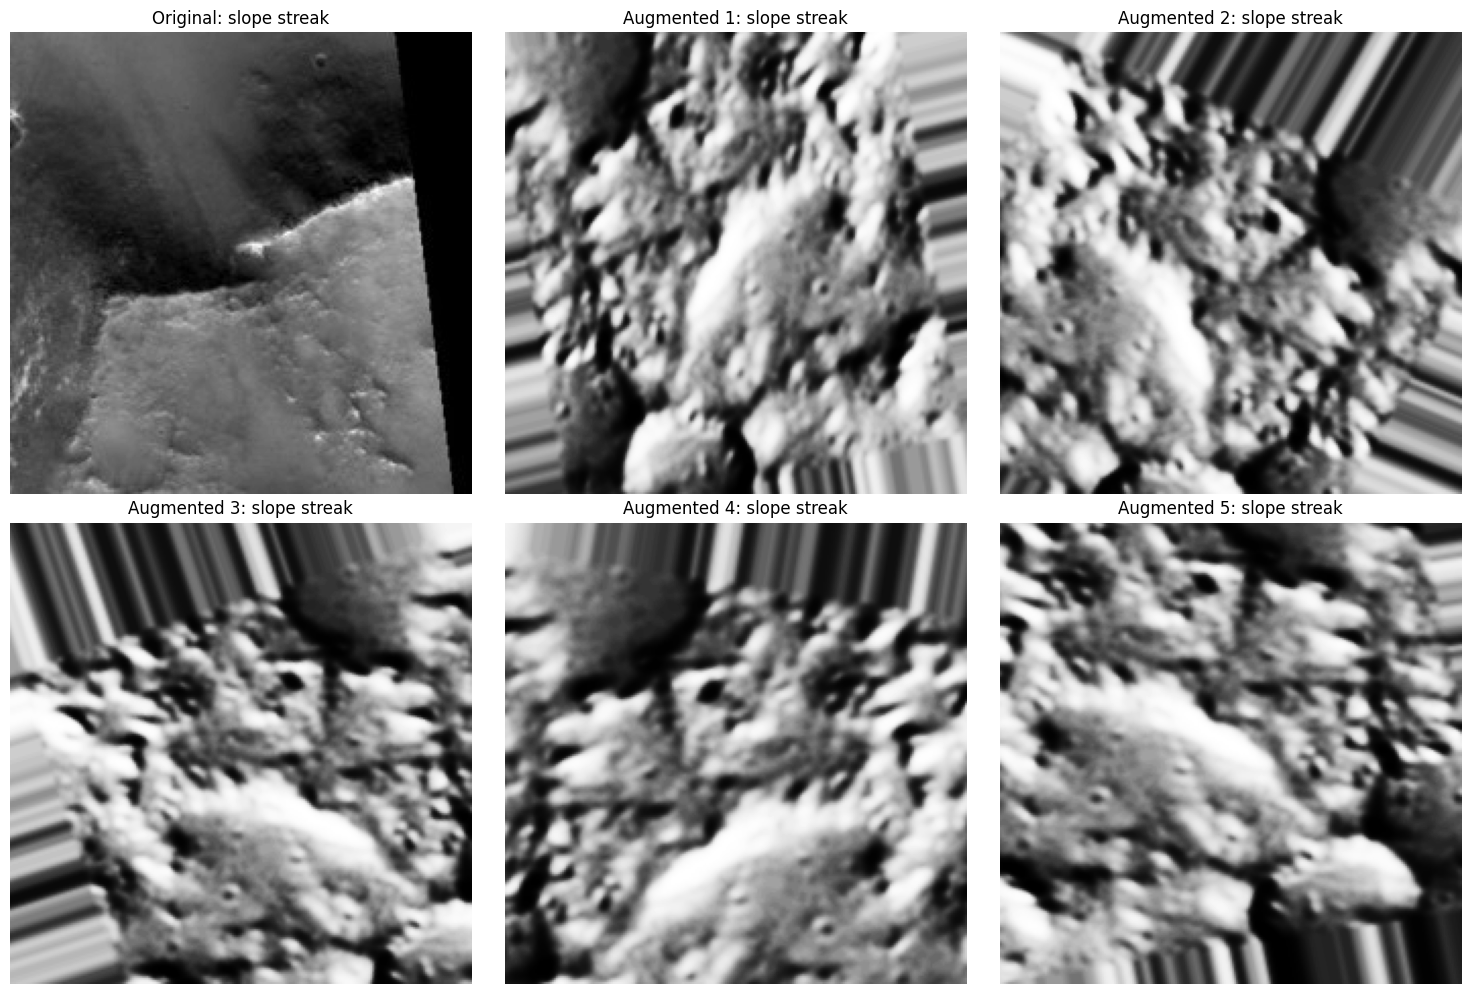

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_images(df):
    num_images=6
    fig,axs=plt.subplots(2,3,figsize=(15,10))
    axs=axs.flatten()
    random_iloc=random.randint(0,len(df)-1)
    random_image=df['File Name'][random_iloc]
    img=mpimg.imread(random_image)
    axs[0].imshow(img , cmap='gray')
    axs[0].set_title(f"Original: {df['Class'][random_iloc]}")
    axs[0].axis("off")
    print(f"Original Image shape: {img.shape}")
    for i in range(1,num_images):
        loc=f'/content/Processed_aug_train_images/{random_iloc}_aug_{i-1}.png'
        img=mpimg.imread(loc)
        axs[i].imshow(img , cmap='gray')
        axs[i].set_title(f"Augmented {i}: {df['Class'][random_iloc]}")
        axs[i].axis("off")
        print(f"Augmented Image {i-1} shape: {img.shape}")

    plt.tight_layout()
    plt.show()
view_random_images(df)

#COLLECTING THE DATA

In [11]:
df=pd.read_csv('/content/Augmented_Up_train.csv')
train_df,test_df=train_test_split(df,test_size=0.1,random_state=1,shuffle=True)
print(f"Length of train data: {len(train_df)}")
print(f"Length of test data: {len(test_df)}")

Length of train data: 33485
Length of test data: 3721


#data generator for simple CNN models
 * Run this below lines and you can run the simple CNN model for faster use GPU
 * You can add your preprocessing method here like zoom,rescale,flip,blur,rotoate etc.

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='File path',
    y_col='Class',
    target_size=(227, 227),
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='File path',
    y_col='Class',
    target_size=(227, 227),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 33485 validated image filenames belonging to 8 classes.
Found 3721 validated image filenames belonging to 8 classes.


#Model 1 (Simple CNN)

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation = 'relu',
                           input_shape=(227,227,3)),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation = 'relu'),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8,activation='softmax')
])

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])


In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 223, 223, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

In [ ]:
history_1 = model_1.fit(
    train_images,
    epochs=10,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=len(test_images),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/10
524/524 [==============================] - 116s 207ms/step - loss: 2.7332 - accuracy: 0.5878 - val_loss: 1.0962 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 2/10
524/524 [==============================] - 112s 213ms/step - loss: 1.0400 - accuracy: 0.6471 - val_loss: 1.0154 - val_accuracy: 0.6557 - lr: 0.0010
Epoch 3/10
524/524 [==============================] - 107s 204ms/step - loss: 0.9143 - accuracy: 0.6817 - val_loss: 0.9990 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 4/10
524/524 [==============================] - 107s 205ms/step - loss: 0.7948 - accuracy: 0.7173 - val_loss: 1.0302 - val_accuracy: 0.6681 - lr: 0.0010
Epoch 5/10
524/524 [==============================] - 109s 208ms/step - loss: 0.6887 - accuracy: 0.7517 - val_loss: 1.0884 - val_accuracy: 0.6662 - lr: 0.0010
Epoch 6/10
524/524 [==============================] - 111s 211ms/step - loss: 0.5899 - accuracy: 0.7863 - val_loss: 1.1954 - val_accuracy: 0.6598 - lr: 0.0010
Epoch 7/10
524/524 [==========================

In [ ]:
results=model_1.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.99903
Test Accuracy: 66.33%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


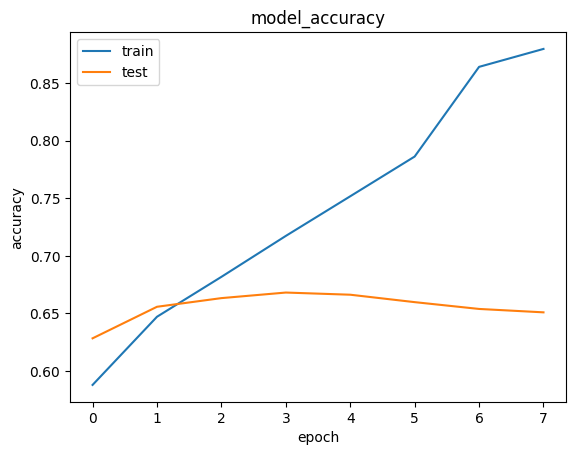

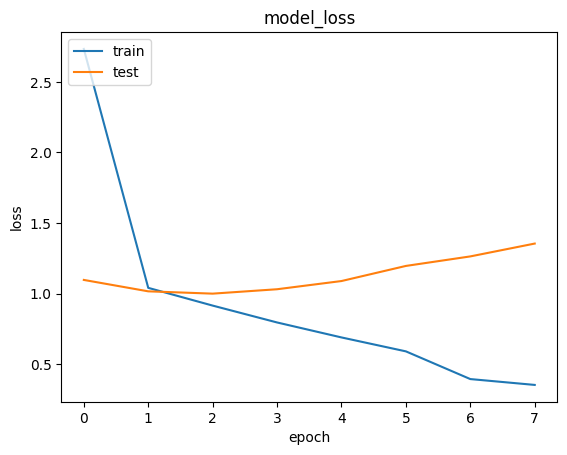

In [ ]:
print(history_1.history.keys())
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Model_2 (More complex)

In [ ]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation = 'relu',
                           input_shape=(227,227,3)),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation = 'relu'),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8,activation='softmax')
])

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 225, 225, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 223, 223, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 107, 107, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                 

In [ ]:
history_2 = model_2.fit(
    train_images,
    epochs=10,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=len(test_images),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/10
524/524 [==============================] - 111s 202ms/step - loss: 5.4175 - accuracy: 0.5857 - val_loss: 1.0246 - val_accuracy: 0.6608 - lr: 0.0010
Epoch 2/10
524/524 [==============================] - 110s 209ms/step - loss: 0.9912 - accuracy: 0.6730 - val_loss: 0.9369 - val_accuracy: 0.6815 - lr: 0.0010
Epoch 3/10
524/524 [==============================] - 111s 211ms/step - loss: 0.7718 - accuracy: 0.7407 - val_loss: 0.9816 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 4/10
524/524 [==============================] - 108s 205ms/step - loss: 0.5762 - accuracy: 0.8047 - val_loss: 1.0322 - val_accuracy: 0.6807 - lr: 0.0010
Epoch 5/10
524/524 [==============================] - 108s 207ms/step - loss: 0.4095 - accuracy: 0.8622 - val_loss: 1.3090 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 6/10
524/524 [==============================] - 107s 203ms/step - loss: 0.2534 - accuracy: 0.9182 - val_loss: 1.3203 - val_accuracy: 0.6805 - lr: 1.0000e-04
Epoch 7/10
524/524 [======================

In [ ]:
results=model_1.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.99903
Test Accuracy: 66.33%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


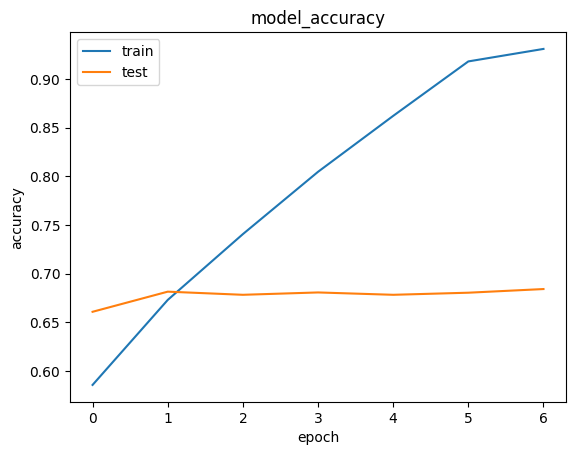

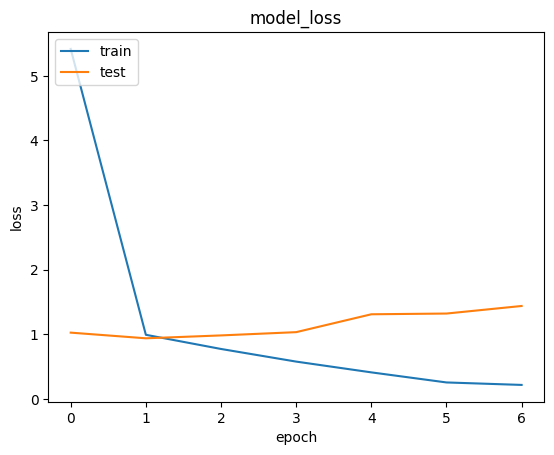

In [ ]:
print(history_2.history.keys())
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#DataLoader for pytorch
* Since we are moving towards more complex models, we shift to pytorch as it is more flexible.
* we define our custom dataloader to load the preprocessed and augmented data

In [13]:
labelencoder=LabelEncoder()
train_df['Class'] = labelencoder.fit_transform(train_df['Class'])
test_df['Class'] = labelencoder.fit_transform(test_df['Class'])
print(f"Total Unique Classes : {train_df['Class'].unique()}")

class MarsSurfaceDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data=csv_file
        self.transform=transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        img_name=self.data.iloc[idx,0]
        image=cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
        label=self.data.iloc[idx,1]
        if self.transform:
            image=self.transform(image)
        return image,label

transform=transforms.Compose([
    transforms.ToTensor()
])

train_dataset=MarsSurfaceDataset(csv_file=train_df,transform=transform)
test_dataset=MarsSurfaceDataset(csv_file=test_df,transform=transform)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

#MODEL 3 ENCODER with CLASSIFIER HEAD

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1=nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=stride,padding=1)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.conv2=nn.Conv2d(out_channels, out_channels,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        out+=self.shortcut(x)
        out=F.relu(out)
        return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
        self.layer2=ResidualBlock(64,128,stride=2)
        self.layer3=ResidualBlock(128,256,stride=2)
        self.layer4=ResidualBlock(256,512,stride=2)

    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        return out

class Classifier(nn.Module):
    def __init__(self,num_classes):
        super(Classifier,self).__init__()
        self.fc=nn.Linear(512*7*7,num_classes)
    def forward(self, x):
        out=F.adaptive_avg_pool2d(x, (7, 7))
        out=out.view(out.size(0),-1)
        out=self.fc(out)
        return out

class EncoderClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EncoderClassifier, self).__init__()
        self.encoder=Encoder()
        self.classifier=Classifier(num_classes)
    def forward(self,x):
        out=self.encoder(x)
        out=self.classifier(out)
        return out

num_classes=8
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model=EncoderClassifier(num_classes).to(device)

Using device: cuda


In [15]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)
num_epochs=20
for epoch in range(num_epochs):
    model.train()
    for images,labels in train_loader:
        images=images.to(device)
        labels=labels.to(device).long()
        outputs=model(images)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.4131
Epoch [2/20], Loss: 0.5899
Epoch [3/20], Loss: 0.5593
Epoch [4/20], Loss: 0.1531
Epoch [5/20], Loss: 0.1550
Epoch [6/20], Loss: 0.0944
Epoch [7/20], Loss: 0.2563
Epoch [8/20], Loss: 0.0346
Epoch [9/20], Loss: 0.1152
Epoch [10/20], Loss: 0.0258
Epoch [11/20], Loss: 0.2747
Epoch [12/20], Loss: 0.1759
Epoch [13/20], Loss: 0.0931
Epoch [14/20], Loss: 0.1146
Epoch [15/20], Loss: 0.1430
Epoch [16/20], Loss: 0.0031
Epoch [17/20], Loss: 0.0101
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0108
Epoch [20/20], Loss: 0.0004


In [16]:
model.eval()
with torch.no_grad():
    correct=0
    total=0
    for images,labels in test_loader:
        #images=images.unsqueeze(1)
        labels=labels.to(device).long()
        images=images.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    print(f'Accuracy of the model on the test images: {100*correct/total:.2f}%')

Accuracy of the model on the test images: 91.64%


#Model with encoderDecoder classification
* We are already using the above custom data laoder to load our data.

In [ ]:
labelencoder=LabelEncoder()
train_df['Class'] = labelencoder.fit_transform(train_df['Class'])
test_df['Class'] = labelencoder.fit_transform(test_df['Class'])
print(f"Total Unique Classes : {train_df['Class'].unique()}")

class MarsSurfaceDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data=csv_file
        self.transform=transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        img_name=self.data.iloc[idx,0]
        image=cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
        label=self.data.iloc[idx,1]
        if self.transform:
            image=self.transform(image)
        return image,label

transform=transforms.Compose([
    transforms.ToTensor()
])

train_dataset=MarsSurfaceDataset(csv_file=train_df,transform=transform)
test_dataset=MarsSurfaceDataset(csv_file=test_df,transform=transform)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1=nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=stride,padding=1)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.conv2=nn.Conv2d(out_channels, out_channels,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(out_channels)
        self.shortcut=nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        out+=self.shortcut(x)
        out=F.relu(out)
        return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
        self.layer2=ResidualBlock(64,128,stride=2)
        self.layer3=ResidualBlock(128,256,stride=2)
        self.layer4=ResidualBlock(256,512,stride=2)

    def forward(self, x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        return out

class Classifier(nn.Module):
    def __init__(self,num_classes):
        super(Classifier,self).__init__()
        self.fc = nn.Linear(512*7*7,num_classes)

    def forward(self, x):
        out=F.adaptive_avg_pool2d(x, (7, 7))
        out=out.view(out.size(0), -1)
        out=self.fc(out)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.upconv1=nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1)
        self.upconv2=nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1)
        self.upconv3=nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1)
        self.upconv4=nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1)
        self.upconv5=nn.ConvTranspose2d(32,1,kernel_size=4,stride=2,padding=1)

    def forward(self, x):
        # print(x.shape)
        out=self.upconv1(x)
        # print(out.shape)
        out=F.relu(out)
        # print(out.shape)
        out=self.upconv2(out)
        # print(out.shape)
        out=F.relu(out)
        # print(out.shape)
        out=self.upconv3(out)
        # print(out.shape)
        out=F.relu(out)
        out=self.upconv4(out)
        # print(out.shape)
        out=F.relu(out)
        out=self.upconv5(out)
        # print(out.shape)
        out=torch.sigmoid(out)
        out=F.interpolate(out, size=(227,227), mode='bilinear',align_corners=False)
        # print(out.shape)
        return out

class EncoderClassifierDecoder(nn.Module):
    def __init__(self, num_classes):
        super(EncoderClassifierDecoder,self).__init__()
        self.encoder=Encoder()
        self.classifier=Classifier(num_classes)
        self.decoder=Decoder()

    def forward(self, x):
        encoded=self.encoder(x)
        classification=self.classifier(encoded)
        reconstruction=self.decoder(encoded)
        # print(f" shape of re cons : {reconstruction.shape}")
        return classification,reconstruction

num_classes=8
model=EncoderClassifierDecoder(num_classes)
# inputs = torch.randn(32, 1, 227, 227)
# class_outputs, reconstruction_outputs = model(inputs)
print(f"TOTAL PARAMETERS : {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

TOTAL PARAMETERS : 7815273


In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_classes =8
model=EncoderClassifierDecoder(num_classes).to(device)
criterion_classification=nn.CrossEntropyLoss()
criterion_reconstruction=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)
num_epochs=20
for epoch in range(num_epochs):
    model.train()
    running_loss=0.0
    correct=0
    total=0

    for images,labels in train_loader:
        images=images.to(device)
        labels=labels.to(device).long()
        class_outputs, reconstruction_outputs = model(images) #Forward Start
        loss_classification=criterion_classification(class_outputs,labels)
        loss_reconstruction=criterion_reconstruction(reconstruction_outputs,images)
        loss=loss_classification+loss_reconstruction
        optimizer.zero_grad() #BackPROP start
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        _,predicted=torch.max(class_outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    epoch_loss=running_loss/len(train_loader)
    epoch_accuracy=100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

model.eval()
with torch.no_grad(): #Eval
    correct=0
    total=0
    running_reconstruction_loss=0.0
    for images,labels in test_loader:
        images=images.to(device)
        labels=labels.to(device).long()
        class_outputs,reconstruction_outputs=model(images)
        loss_reconstruction=criterion_reconstruction(reconstruction_outputs,images)
        running_reconstruction_loss+=loss_reconstruction.item()
        _, predicted=torch.max(class_outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    accuracy=100*correct/total
    reconstruction_loss=running_reconstruction_loss/len(test_loader)

    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    print(f'Reconstruction Loss on the test images: {reconstruction_loss:.4f}')

Using device: cuda
Epoch [1/20], Loss: 0.9268, Accuracy: 71.30%
Epoch [2/20], Loss: 0.5577, Accuracy: 81.62%
Epoch [3/20], Loss: 0.4306, Accuracy: 85.86%
Epoch [4/20], Loss: 0.3459, Accuracy: 88.76%
Epoch [5/20], Loss: 0.2874, Accuracy: 90.61%
Epoch [6/20], Loss: 0.2322, Accuracy: 92.69%
Epoch [7/20], Loss: 0.1870, Accuracy: 94.00%
Epoch [8/20], Loss: 0.1491, Accuracy: 95.47%
Epoch [9/20], Loss: 0.1267, Accuracy: 96.40%
Epoch [10/20], Loss: 0.1031, Accuracy: 97.23%
Epoch [11/20], Loss: 0.0909, Accuracy: 97.68%
Epoch [12/20], Loss: 0.0833, Accuracy: 98.06%
Epoch [13/20], Loss: 0.0771, Accuracy: 98.17%
Epoch [14/20], Loss: 0.0670, Accuracy: 98.60%
Epoch [15/20], Loss: 0.0742, Accuracy: 98.32%
Epoch [16/20], Loss: 0.0601, Accuracy: 98.82%
Epoch [17/20], Loss: 0.0567, Accuracy: 98.90%
Epoch [18/20], Loss: 0.0627, Accuracy: 98.72%
Epoch [19/20], Loss: 0.0543, Accuracy: 98.98%
Epoch [20/20], Loss: 0.0525, Accuracy: 99.05%
Accuracy of the model on the test images: 91.91%
Reconstruction Loss o

In [ ]:
num_epochs=20
for epoch in range(num_epochs):
    model.train()
    running_loss=0.0
    correct=0
    total=0

    for images,labels in train_loader:
        images=images.to(device)
        labels=labels.to(device).long()
        class_outputs, reconstruction_outputs = model(images) #Forward Start
        loss_classification=criterion_classification(class_outputs,labels)
        loss_reconstruction=criterion_reconstruction(reconstruction_outputs,images)
        loss=loss_classification+loss_reconstruction
        optimizer.zero_grad() #BackPROP start
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        _,predicted=torch.max(class_outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    epoch_loss=running_loss/len(train_loader)
    epoch_accuracy=100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

model.eval()
with torch.no_grad(): #Eval
    correct=0
    total=0
    running_reconstruction_loss=0.0
    for images,labels in test_loader:
        images=images.to(device)
        labels=labels.to(device).long()
        class_outputs,reconstruction_outputs=model(images)
        loss_reconstruction=criterion_reconstruction(reconstruction_outputs,images)
        running_reconstruction_loss+=loss_reconstruction.item()
        _, predicted=torch.max(class_outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    accuracy=100*correct/total
    reconstruction_loss=running_reconstruction_loss/len(test_loader)

    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    print(f'Reconstruction Loss on the test images: {reconstruction_loss:.4f}')

Epoch [1/20], Loss: 0.0501, Accuracy: 99.20%
Epoch [2/20], Loss: 0.0523, Accuracy: 99.03%
Epoch [3/20], Loss: 0.0464, Accuracy: 99.26%
Epoch [4/20], Loss: 0.0502, Accuracy: 99.08%
Epoch [5/20], Loss: 0.0438, Accuracy: 99.28%
Epoch [6/20], Loss: 0.0444, Accuracy: 99.35%
Epoch [7/20], Loss: 0.0459, Accuracy: 99.34%
Epoch [8/20], Loss: 0.0419, Accuracy: 99.43%
Epoch [9/20], Loss: 0.0453, Accuracy: 99.32%
Epoch [10/20], Loss: 0.0435, Accuracy: 99.36%
Epoch [11/20], Loss: 0.0436, Accuracy: 99.38%
Epoch [12/20], Loss: 0.0387, Accuracy: 99.53%
Epoch [13/20], Loss: 0.0425, Accuracy: 99.46%
Epoch [14/20], Loss: 0.0374, Accuracy: 99.57%
Epoch [15/20], Loss: 0.0392, Accuracy: 99.51%
Epoch [16/20], Loss: 0.0429, Accuracy: 99.36%
Epoch [17/20], Loss: 0.0345, Accuracy: 99.61%
Epoch [18/20], Loss: 0.0463, Accuracy: 99.38%
Epoch [19/20], Loss: 0.0333, Accuracy: 99.62%
Epoch [20/20], Loss: 0.0350, Accuracy: 99.61%
Accuracy of the model on the test images: 92.07%
Reconstruction Loss on the test images: 

##saving the model

In [ ]:
torch.save(model.state_dict(), 'model_EncoderDecoderClassifier_40_epoch.pth')

##Making predictions on unlabelled data

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir=image_dir
        self.transform=transform
        self.image_files=[f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self,idx):
        img_name=self.image_files[idx]
        img_path=os.path.join(self.image_dir, img_name)
        image=Image.open(img_path).convert('L')
        if self.transform:
            image=self.transform(image)
        return image,img_name

transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
])
unlabeled_dataset=UnlabeledDataset(image_dir='/content/test_dataset',transform=transform)
unlabeled_loader=DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)


In [ ]:
import pandas as pd
model.eval()
predictions=[]
with torch.no_grad():
    for images,img_names in unlabeled_loader:
        images=images.to(device)
        class_outputs,_=model(images)
        _,predicted_labels=torch.max(class_outputs, 1)
        for img_name,label in zip(img_names, predicted_labels):
            predictions.append((img_name,label.item()))
df=pd.DataFrame(predictions, columns=['Filename', 'PredictedLabel'])
df['PredictedLabel']=labelencoder.inverse_transform(df['PredictedLabel'])
df.to_csv('predictions_by_ENCODER_DECODER_CNNC_40_epochs.csv', index=False)

#Model Visvualization

In [ ]:
counter=1
recons = 0;
for images, labels in test_loader:
        images =images.to(device)
        labels =labels.to(device).long()
        class_outputs, recons = model(images)
        if counter==1:
          break;
recons.size()

torch.Size([32, 1, 227, 227])

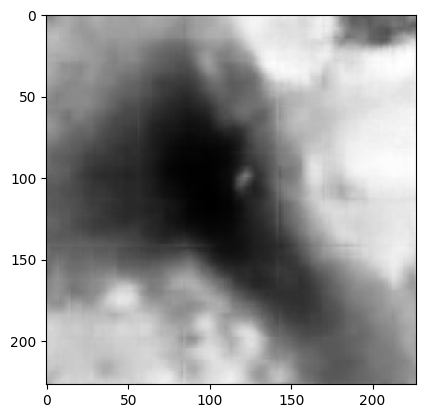

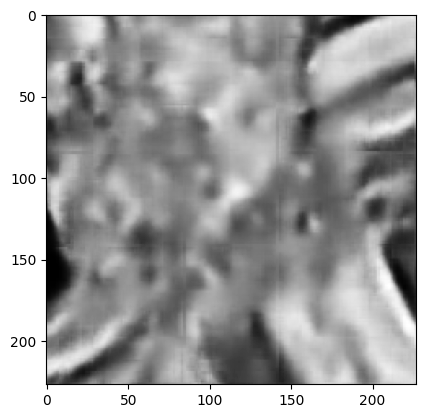

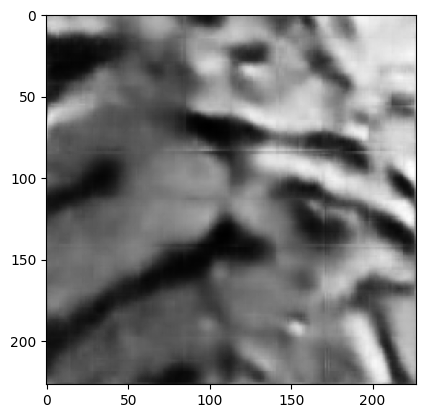

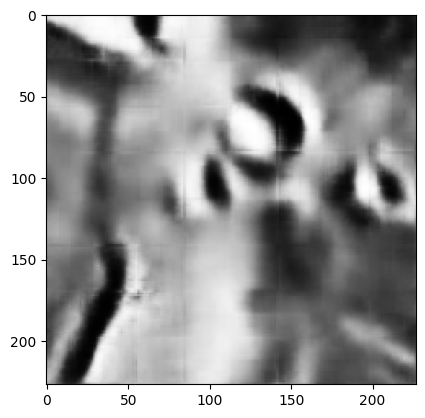

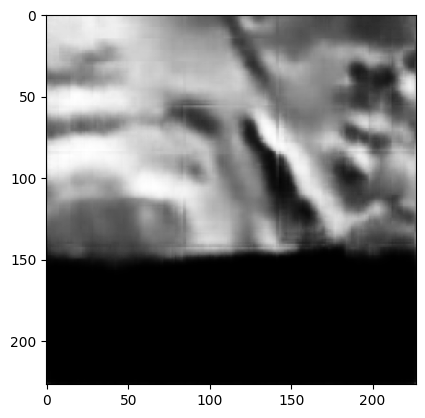

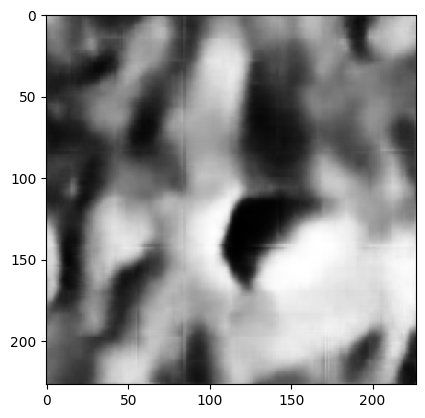

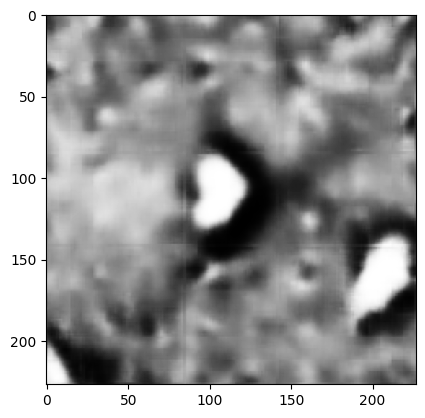

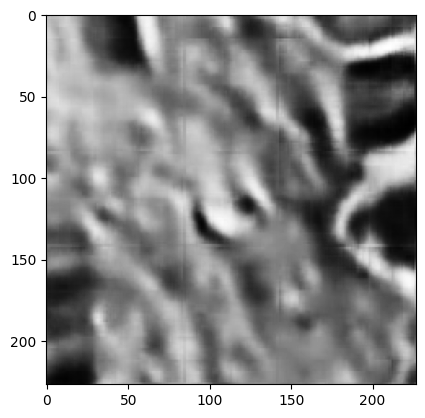

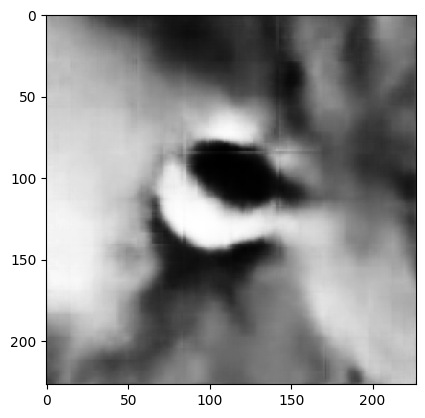

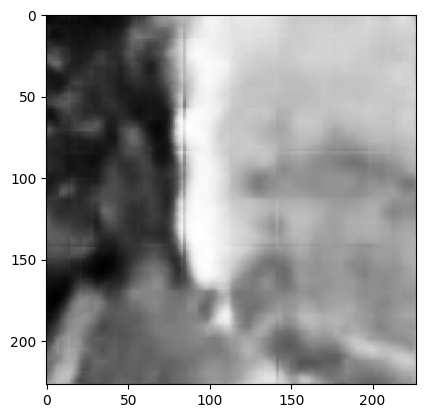

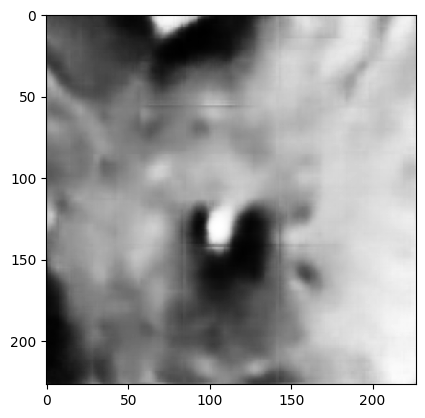

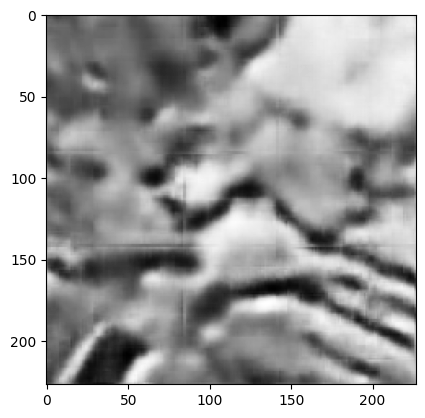

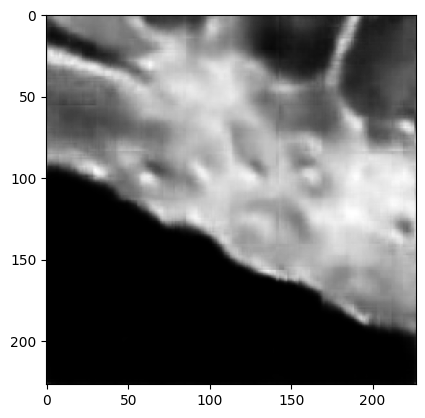

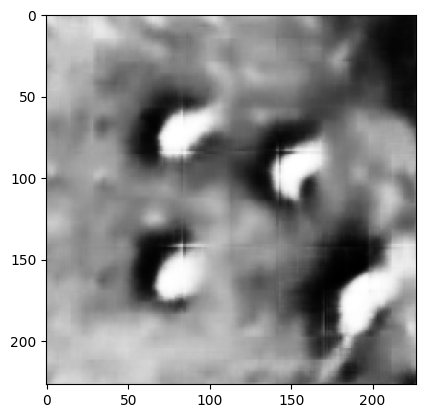

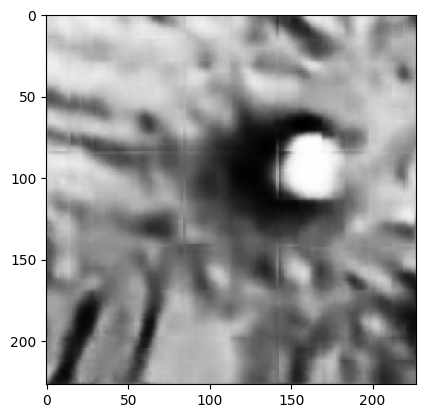

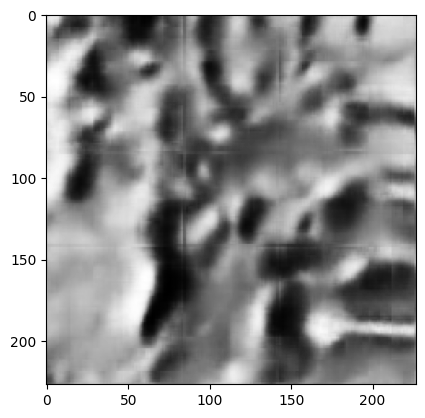

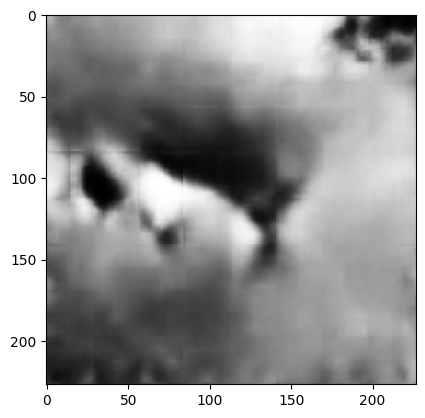

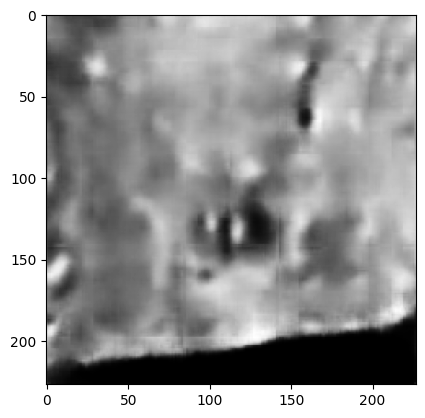

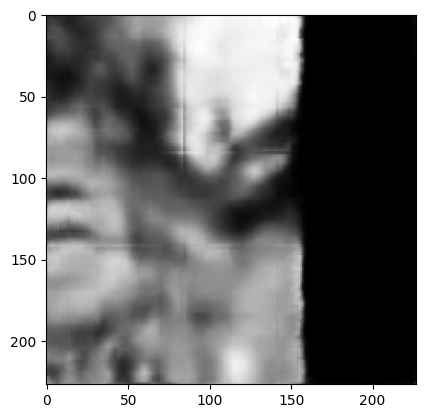

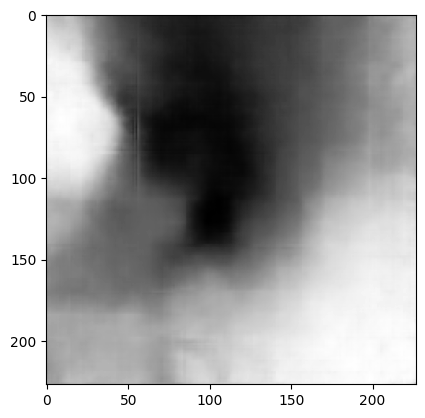

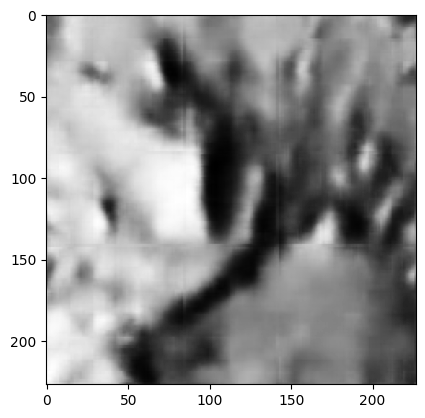

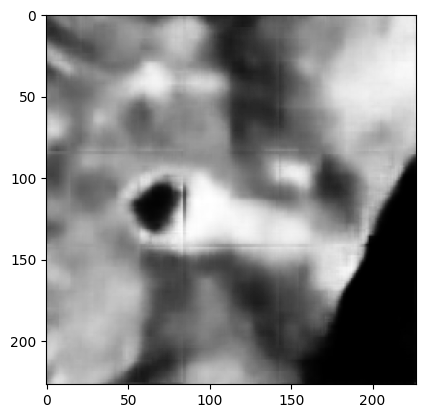

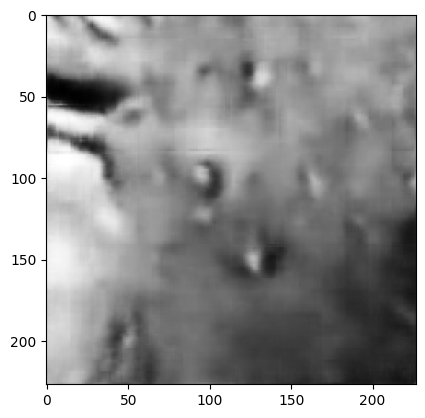

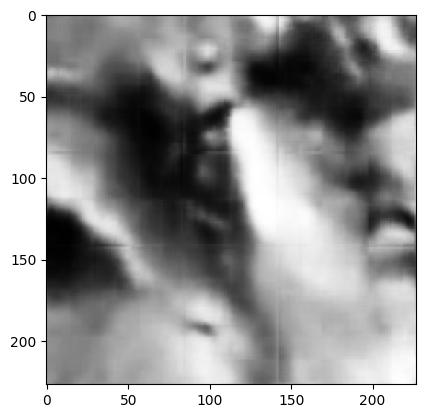

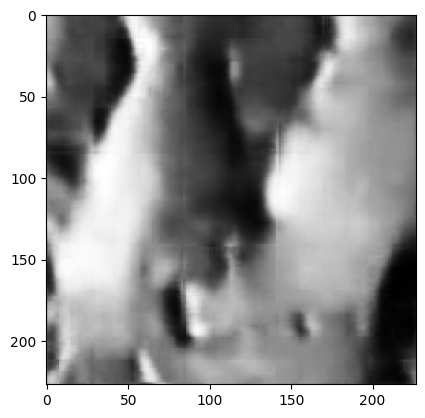

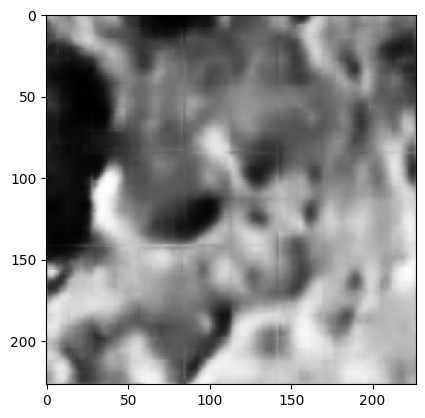

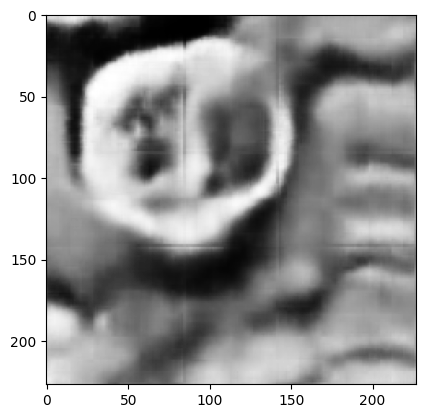

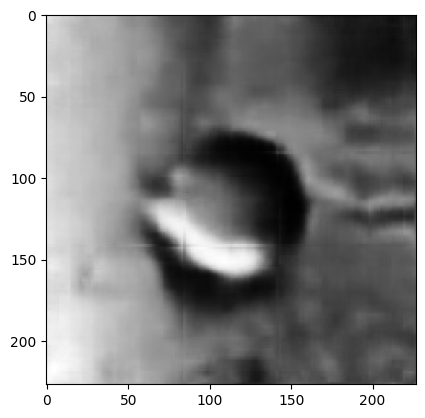

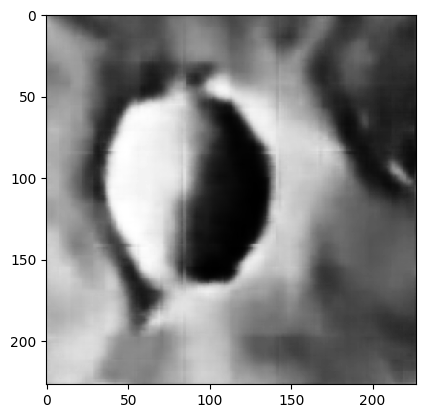

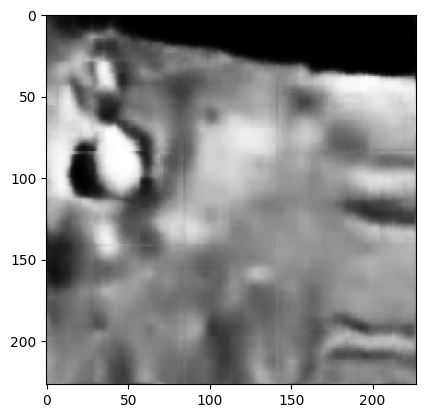

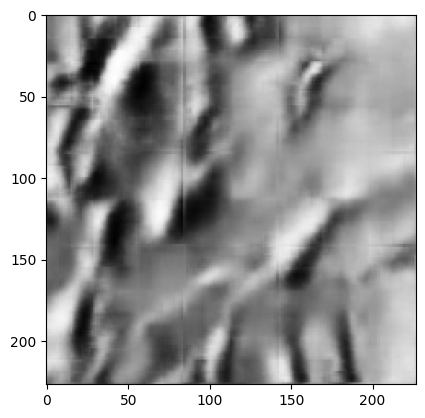

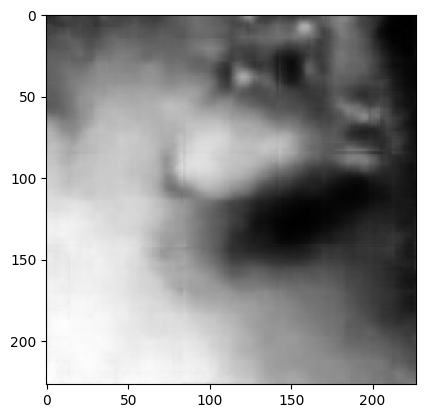

In [ ]:
recons.size()
new = recons.squeeze(1)
for i in range (32):
  k = recons[i]
  k = k.squeeze(0)
  k = k.cpu()
  # Plotting the image
  k = k.detach().numpy()
  plt.imshow(k , cmap = 'gray')
  plt.show()